# Overview
In this notebook, we'll look beyond our target concepts to look for semantic modifiers using the **ConText** algorithm. We'll then see how to detect which section of a clinical document a concept is found in.

In [1]:
import spacy
import medspacy

from IPython.display import YouTubeVideo

In [2]:
nlp = medspacy.load()

In [3]:
nlp.pipe_names

['tagger',
 'parser',
 'target_matcher',
 'sectionizer',
 'context',
 'postprocessor']

First, let's set up our model to extract some of the concepts we saw in the previous notebook:

In [4]:
from medspacy.ner import TargetRule

In [5]:
target_matcher = nlp.get_pipe("target_matcher")

In [6]:
# Add rules from previous notebook for target extraction
target_rules = [
    TargetRule("pneumonia", "PROBLEM"),
    TargetRule("afib", "PROBLEM"),
    TargetRule("CHF", "PROBLEM"),
    TargetRule("Breast Cancer", "PROBLEM"),
    TargetRule("Alzheimer's", "PROBLEM"),
    TargetRule("metformin", "TREATMENT"),
    TargetRule("CKD", "PROBLEM", pattern=[
        {"LOWER": "ckd"}, # Token 1
        {"LOWER": "stage"}, # Token 2
        {"LIKE_NUM": True} # Token 3
        ]),
    
    TargetRule("Type II Diabetes Mellitus", "PROBLEM", 
              pattern=[
                  {"LOWER": "type"},
                  {"LOWER": {"IN": ["2", "ii", "two"]}},
                  {"LOWER": {"IN": ["dm", "diabetes"]}},
                  {"LOWER": "mellitus", "OP": "?"}
              ]),
]

In [7]:
target_matcher.add(target_rules)

# III. Contextual analysis
Clinical text often contains mentions of concepts which the patient did not actually experience. For example:

- "There is *no evidence of* **pneumonia**"
- "*Mother* with **breast cancer**"
- "Patient presents for *r/o* **COVID-19**"

In all of these instances, we need to use the contextual clues around the entity to assert attributes like negation, experiencer, and uncertainty.

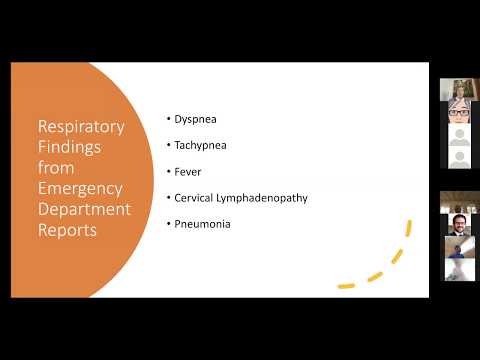

In [8]:
YouTubeVideo("UEm7H8cfz80", start=1747, end=1885, rel=0)

## ConText Algorithm

One method for this is the [ConText algorithm](https://www.sciencedirect.com/science/article/pii/S1532046409000744). ConText links target entities like problems with semantic modifiers like those shown above. 

ConText's algorithm is extremely simple. Once you have named entities identified in a sentence, you can run ConText to determine whether any of them are not affirmed for the patient at the time the note was written. Here is an example for identifying a negated named entity:

1. Mark all ConText terms from your dictionary in the sentence
2. All named entities between the negation term and the end of the sentence are changed from "affirmed" to "negated"
3. Unless there is a termination term - then all named entities between the negation term and the termination term are changed from "affirmed" to "negated".


Here is an example of how it works when "but" is included as a termination term in your dictionary

<img alt="an example visualization of ConText" src="./media/ConText-negation-example.png" width="500">

You can decide what types of modifiers you want ConText to address. If I create a modifier for experiencer, and include the word "mother" in my dictionary, then the experiencer is no longer the patient, which is the default assumption, but the person represented by the term "mother": 

<img alt="an example visualization of ConText" src="./media/ConText-experiencer-example.png" width="500">

The medSpaCy implementation of ConText is [cycontext](https://github.com/medspacy/cycontext).

Here we'll show the basic usage of ConText. When instantiating ConText, we can use default rules and then add additional as needed. See the [cycontext](https://github.com/medspacy/cycontext) repository for more detailed examples and tutorials.

In [9]:
from medspacy.ner import TargetRule
from medspacy.context import ConTextItem
from medspacy.visualization import visualize_ent, visualize_dep

In [10]:
doc = nlp("There is no evidence of pneumonia.")

We can visualize the target and modifiers using two functions from `medspacy.visualization`. `visualize_ent` will highlight the spans of both target and modifier concepts. `visualize_dep` will show arrows between concepts to show which targets are modified by modifiers.

In [11]:
visualize_ent(doc)

In [12]:
visualize_dep(doc)

In [13]:
texts = [
    "Patient presents for management of Type II Diabetes Mellitus",
    "No evidence of pneumonia",
    "Past medical history significant for afib, CHF, and CKD Stage 3, now CKD stage five.",
    "Mother with breast cancer",
    "continue metformin for type 2 dm",
    "Her grandma was recently diagnosed with Alzheimer's"
]

In [14]:
docs = list(nlp.pipe(texts))

### TODO
Change `idx` to go through each of the texts and see target/modifier relationships.

In [15]:
idx = 0

In [16]:
visualize_ent(docs[idx])

In [17]:
visualize_dep(docs[idx])

## Adding rules to ConText
MedSpaCy comes with default rules for matching targets and modifiers. But you'll often find new examples which aren't included in the default rules. Let's see now how to add a rule.

In the sentence **"Her grandma was recently diagnosed with Alzheimer's"**, medSpaCy fails to recognize that **"grandma"** is a **"FAMILY"** modifier. 

In [18]:
text = "Her grandma was recently diagnosed with Alzheimer's"
doc = nlp(text)

In [19]:
visualize_ent(doc)

We can add this rule using the `ConTextItem` class and adding to the `context` component.

In [20]:
from medspacy.context import ConTextItem

In [21]:
context = nlp.get_pipe("context")

This class uses the same arguments as `TargetMatcher`, `literal` and `category`:

In [22]:
new_item_data = [
    ConTextItem(literal="grandma", category="FAMILY"),
]

In [23]:
context.add(new_item_data)

In [24]:
doc = nlp(text)

In [25]:
visualize_ent(doc)

In [26]:
visualize_dep(doc)

### TODO
Add a ConText item rule to create a negation modifier for the phrase **"is not evident"**. Then add the rule to `context.add()` and process the text below. Make sure that **"is not evident"** modifies **"Pneumonia"**.

The list below shows the possible values for the `category` argument:
- 'FAMILY',
- 'HISTORICAL',
- 'HYPOTHETICAL',
- 'NEGATED_EXISTENCE',
- 'POSSIBLE_EXISTENCE'

In [27]:
new_item_data2 = [
    ConTextItem(literal=____, category=____),
]

NameError: name '____' is not defined

In [28]:
context.add(____)

NameError: name '____' is not defined

In [29]:
doc = nlp("Pneumonia is not evident.")

In [30]:
visualize_dep(doc)

# IV.  Section detection
Another important aspect of understanding what is being described in text is the structure of the document. Here is a discussion about determining whether a report describes cervical lymphadenopathy:

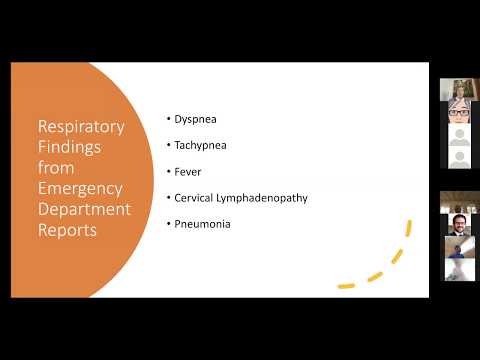

In [31]:
YouTubeVideo("UEm7H8cfz80", start=1205, end=1303, rel=0)


Clinical notes often contain a certain structure. The one example of this is the [SOAP note](https://www.globalpremeds.com/blog/2015/01/02/understanding-soap-format-for-clinical-rounds/). Different parts of the notes have different significance. For example, a document listed in the **Past Medical History** or **Problem List** is likely a historical condition which may not be relevant to a patient visit, where as the **Assessment/Plan** will be contain more up-to-date diagnoses.

MedSpaCy will detect sections through the `sectionizer` component. We can then visualize the section headers in using `visualize_ent`.

In [32]:
sectionizer = nlp.get_pipe("sectionizer")

In [33]:
text = """Past Medical History:
1. Type II DM
2. Afib
3. CKD Stage 3

Family History:
1. Breast Cancer


Reason for this examination: Possible pneumonia.

IMPRESSION:
No evidence of pneumonia.

Assessment/Plan:
Continue metformin for type 2 dm.
"""

In [34]:
doc = nlp(text)

In [35]:
visualize_ent(doc)

We can see all of the section titles in the doc by calling `doc._.section_titles`. We can also see which section an entity occured in using `ent._.section_title`:

In [36]:
print(doc._.section_titles)

['past_medical_history', 'family_history', 'reason_for_examination', 'observation_and_plan', 'observation_and_plan']


In [37]:
for ent in doc.ents:
    print(ent, ent._.section_title)

Type II DM past_medical_history
Afib past_medical_history
CKD Stage 3 past_medical_history
Breast Cancer family_history
pneumonia reason_for_examination
pneumonia observation_and_plan
metformin observation_and_plan
type 2 dm observation_and_plan


## Adding rules to the sectionizer
Just like with `context`, you'll want to add new section titles to the `sectionizer` component. We can do this by writing patterns which are dictionaries with two keys:
- `section_title`: The normalized section title
- `pattern`: The pattern to match in the text

We then add these patterns using `sectionizer.add()`.

For example, we can see below that medSpaCy fails to recognize **"Previous Medical History"** to be equivalent to **"Past Medical History"**.

In [ ]:
text = """Previous Medical History:
Pneumonia in 2012
"""

In [ ]:
doc = nlp(text)

In [ ]:
visualize_ent(doc)

Let's add a pattern here to match it.

In [ ]:
sectionizer = nlp.get_pipe("sectionizer")

In [ ]:
pattern = {
    "section_title": "past_medical_history",
    "pattern": "Previous Medical History:"
}

In [ ]:
sectionizer.add([pattern])

In [ ]:
doc = nlp(text)
visualize_ent(doc)

Here is a list of all of the standardized titles in medSpaCy's default section rules:

In [ ]:
sectionizer.section_titles

### TODO
Look at the note below. Identify any section titles which aren't highlighted by medSpaCy. Then add patterns to the sectionizer to match them. For the `"section_title"` key, you can either choose from one of the standardized titles below or choose your own.

In [ ]:
text = """\
Active Medical Issues:
- Hip Pain
- Hypertension
- CHF

Medical Decision Making:
Patient understands benefits and risks of surgery.

Instructions for Home Care:
Dress wound twice a day.
"""

In [ ]:
new_section_patterns = [
    {"section_title": ____, "pattern": ____},
    # ...
]

In [ ]:
sectionizer.____(____)

In [ ]:
doc = nlp(text)
visualize_ent(doc)

# What if we used machine learning rather than a rules-based system?

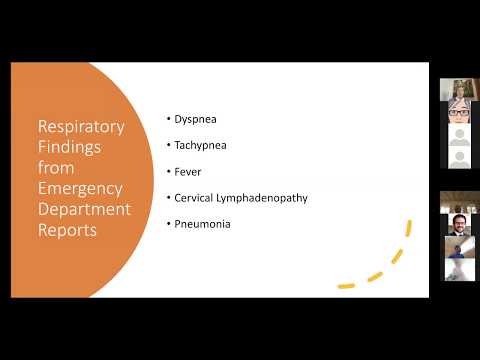

In [38]:
YouTubeVideo("UEm7H8cfz80", start=2600, end=2708, rel=0)

# Next Steps
So far, we've used medSpaCy to write rules for extracting concepts in the text and for identifying other attributes like negation and an entity's section in the note. Next we'll see how to use **machine learning** as an alternative method for concept extraction.

[nlp-04-machine-learning-ner.ipynb](nlp-04-machine-learning-ner.ipynb)